In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load dataset 

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("The shape of train dataset is: ", train.shape)
print("The shape of test dataset is: ", test.shape)

display(train.head(5), test.head(5))

The shape of train dataset is:  (131662, 14)
The shape of test dataset is:  (87395, 13)


,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,A,10.0,2.57438,A,B,3.68000,2,NaN,46,63,Male
1,T0005689462,32.15,B,10.0,2.85143,A,A,1.59375,0,65.0,49,80,Female
2,T0005689463,10.38,C,4.0,2.70530,A,D,4.50500,0,NaN,47,74,Male
3,T0005689466,14.94,NaN,6.0,2.48159,C,E,4.53000,0,63.0,43,54,Male
4,T0005689468,32.03,B,7.0,2.81598,A,K,4.60125,3,96.0,44,56,Male


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
Trip_ID                        131662 non-null object
Trip_Distance                  131662 non-null float64
Type_of_Cab                    111452 non-null object
Customer_Since_Months          125742 non-null float64
Life_Style_Index               111469 non-null float64
Confidence_Life_Style_Index    111469 non-null object
Destination_Type               131662 non-null object
Customer_Rating                131662 non-null float64
Cancellation_Last_1Month       131662 non-null int64
Var1                           60632 non-null float64
Var2                           131662 non-null int64
Var3                           131662 non-null int64
Gender                         131662 non-null object
Surge_Pricing_Type             131662 non-null int64
dtypes: float64(5), int64(4), object(5)
memory usage: 14.1+ MB


## Exploratory data analysis 

### describe numeric and categorical features 

In [4]:
display(train.describe().T, test.describe().T)

,count,mean,std,min,25%,50%,75%,max
Trip_Distance,131662.0,44.200909,25.522882,0.31000,24.58000,38.20000,60.73000,109.23000
Customer_Since_Months,125742.0,6.016661,3.626887,0.00000,3.00000,6.00000,10.00000,10.00000
Life_Style_Index,111469.0,2.802064,0.225796,1.59638,2.65473,2.79805,2.94678,4.87511
Customer_Rating,131662.0,2.849458,0.980675,0.00125,2.15250,2.89500,3.58250,5.00000
Cancellation_Last_1Month,131662.0,0.782838,1.037559,0.00000,0.00000,0.00000,1.00000,8.00000
Var1,60632.0,64.202698,21.820447,30.00000,46.00000,61.00000,80.00000,210.00000
Var2,131662.0,51.202800,4.986142,40.00000,48.00000,50.00000,54.00000,124.00000
Var3,131662.0,75.099019,11.578278,52.00000,67.00000,74.00000,82.00000,206.00000
Surge_Pricing_Type,131662.0,2.155747,0.738164,1.00000,2.00000,2.00000,3.00000,3.00000


,count,mean,std,min,25%,50%,75%,max
Trip_Distance,87395.0,44.095174,25.483993,1.55000,24.540000,38.06000,60.690000,109.23000
Customer_Since_Months,83429.0,5.990051,3.626861,0.00000,3.000000,6.00000,10.000000,10.00000
Life_Style_Index,74068.0,2.803392,0.227113,1.31785,2.654518,2.79863,2.949053,4.87192
Customer_Rating,87395.0,2.847389,0.981744,0.00125,2.152500,2.89500,3.580000,5.00000
Cancellation_Last_1Month,87395.0,0.783031,1.034266,0.00000,0.000000,0.00000,1.000000,8.00000
Var1,40606.0,63.936610,21.636247,30.00000,45.000000,61.00000,79.000000,178.00000
Var2,87395.0,51.162160,4.956831,41.00000,48.000000,50.00000,54.000000,116.00000
Var3,87395.0,75.015699,11.582761,52.00000,67.000000,73.00000,82.000000,169.00000


In [5]:
display(train.describe(include="object").T, test.describe(include="object").T)

,count,unique,top,freq
Trip_ID,131662,131662,T0005857447,1
Type_of_Cab,111452,5,B,31136
Confidence_Life_Style_Index,111469,3,B,40355
Destination_Type,131662,14,A,77597
Gender,131662,2,Male,93900


,count,unique,top,freq
Trip_ID,87395,87395,T0005774312,1
Type_of_Cab,74237,5,B,20449
Confidence_Life_Style_Index,74068,3,B,26910
Destination_Type,87395,14,A,51413
Gender,87395,2,Male,62228


### check missing values 

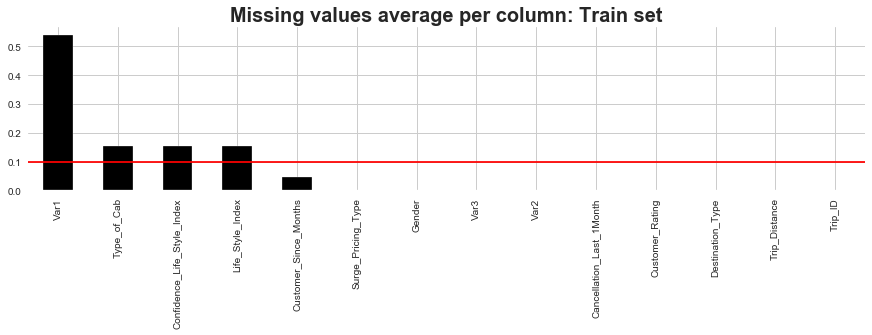

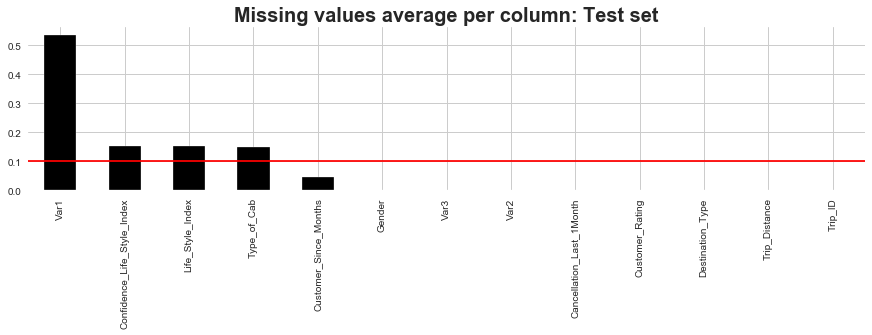

In [6]:
plt.style.use('seaborn')
sns.set_style('whitegrid')

plt.subplots(0,0,figsize=(15,3))

train.isnull().mean().sort_values(ascending=False).plot.bar(color='black')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Missing values average per column: Train set', fontsize=20, weight='bold' )
plt.show()

plt.subplots(1,0,figsize=(15,3))

test.isnull().mean().sort_values(ascending=False).plot.bar(color='black')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Missing values average per column: Test set', fontsize=20, weight='bold' )
plt.show()

#### fill missing value with mean or median 

**check the distribution of Var1 and Life_Style_Index** 

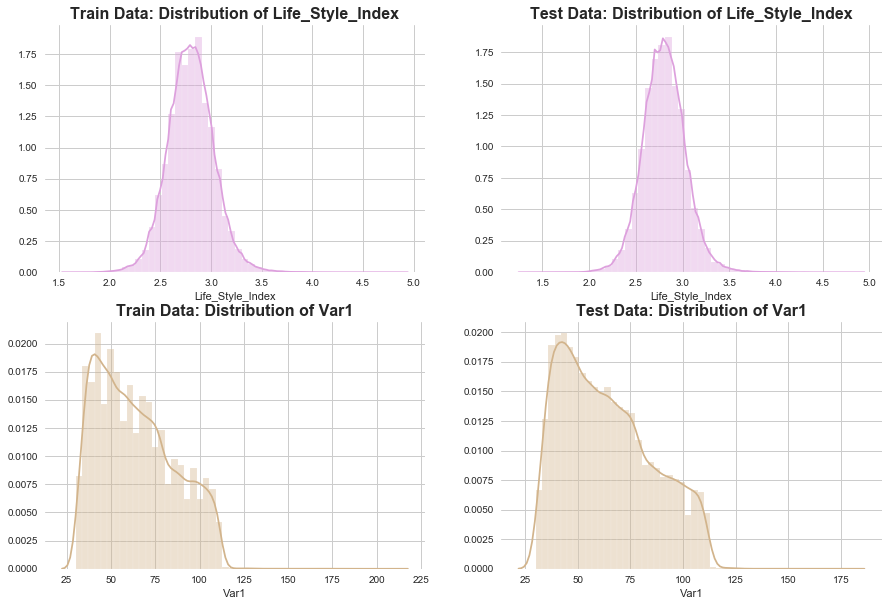

In [7]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot2grid((2,2),(0,0), rowspan=1, colspan=1)
sns.distplot(train.Life_Style_Index.dropna(), color='plum')
plt.title('Train Data: Distribution of Life_Style_Index',weight='bold', fontsize=16)

ax1 = plt.subplot2grid((2,2),(0,1), rowspan=1, colspan=1)
sns.distplot(test.Life_Style_Index.dropna(), color='plum')
plt.title('Test Data: Distribution of Life_Style_Index',weight='bold', fontsize=16)

ax2 = plt.subplot2grid((2,2),(1,0), rowspan=1, colspan=1)
sns.distplot(train.Var1.dropna(), color='tan')
plt.title('Train Data: Distribution of Var1',weight='bold', fontsize=16)

ax2 = plt.subplot2grid((2,2),(1,1), rowspan=1, colspan=1)
sns.distplot(test.Var1.dropna(), color='tan')
plt.title('Test Data: Distribution of Var1',weight='bold', fontsize=16)

plt.show()

*The Life_Style_Index is nearly normally distributed, but the Var1 is left skewed and the shape is not very normal. So the mean of Life_Style_Index is used to fill na and median is used to fill Var1 na.*

In [7]:
train_filled_naive = train.copy()
test_filled_naive = test.copy()

## categorical variable / non continuous variable fillna
# fill Type_of_Cab na with "N"
train_filled_naive.Type_of_Cab.fillna("N",inplace=True)
test_filled_naive.Type_of_Cab.fillna("N",inplace=True)
# change Customer_Since_Months data type to int and fill na with 99
train_filled_naive.Customer_Since_Months.fillna(99,inplace=True)
test_filled_naive.Customer_Since_Months.fillna(99,inplace=True)
train_filled_naive.Customer_Since_Months = train_filled_naive.Customer_Since_Months.astype(int)
test_filled_naive.Customer_Since_Months = test_filled_naive.Customer_Since_Months.astype(int)

# fill Confidence_Life_Style_Index with "N"
train_filled_naive.Confidence_Life_Style_Index.fillna('N',inplace=True)
test_filled_naive.Confidence_Life_Style_Index.fillna('N',inplace=True)

## continuous variable fill na with mean or median 
# fill Life_Style_Index with mean 
train_filled_naive.Life_Style_Index.fillna(train_filled_naive.Life_Style_Index.mean(),inplace=True)
test_filled_naive.Life_Style_Index.fillna(test_filled_naive.Life_Style_Index.mean(),inplace=True)
# fill Var1 with median
train_filled_naive.Var1.fillna(train_filled_naive.Var1.median(),inplace=True)
test_filled_naive.Var1.fillna(test_filled_naive.Var1.median(),inplace=True)

print(train_filled_naive.info())
print(test_filled_naive.info())
display(train_filled_naive.head(), test_filled_naive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
Trip_ID                        131662 non-null object
Trip_Distance                  131662 non-null float64
Type_of_Cab                    131662 non-null object
Customer_Since_Months          131662 non-null int64
Life_Style_Index               131662 non-null float64
Confidence_Life_Style_Index    131662 non-null object
Destination_Type               131662 non-null object
Customer_Rating                131662 non-null float64
Cancellation_Last_1Month       131662 non-null int64
Var1                           131662 non-null float64
Var2                           131662 non-null int64
Var3                           131662 non-null int64
Gender                         131662 non-null object
Surge_Pricing_Type             131662 non-null int64
dtypes: float64(4), int64(5), object(5)
memory usage: 14.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87395 entries, 0

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1,2.427690,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10,2.782450,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,N,10,2.802064,N,E,3.50125,2,61.0,56,77,Male,2
3,T0005689465,61.56,C,10,2.802064,N,A,3.45375,0,61.0,52,74,Male,3
4,T0005689467,54.95,C,10,3.034530,B,A,3.40250,4,51.0,49,102,Male,2


,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,A,10,2.57438,A,B,3.68000,2,61.0,46,63,Male
1,T0005689462,32.15,B,10,2.85143,A,A,1.59375,0,65.0,49,80,Female
2,T0005689463,10.38,C,4,2.70530,A,D,4.50500,0,61.0,47,74,Male
3,T0005689466,14.94,N,6,2.48159,C,E,4.53000,0,63.0,43,54,Male
4,T0005689468,32.03,B,7,2.81598,A,K,4.60125,3,96.0,44,56,Male


#### fill missing values with knn imputation 

In [8]:
objList = ['Type_of_Cab', 'Destination_Type', 'Confidence_Life_Style_Index', 'Gender']

train_encoded = train.copy()
le = LabelEncoder()
for feature in objList:
    train_encoded[feature] = le.fit_transform(train_encoded[feature].astype(str))
    
train_encoded.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1,1.0,2.42769,0,0,3.90500,0,40.0,46,60,0,2
1,T0005689461,29.47,1,10.0,2.78245,1,0,3.45000,0,38.0,56,78,1,2
2,T0005689464,41.58,5,10.0,NaN,3,4,3.50125,2,NaN,56,77,1,2
3,T0005689465,61.56,2,10.0,NaN,3,0,3.45375,0,NaN,52,74,1,3
4,T0005689467,54.95,2,10.0,3.03453,1,0,3.40250,4,51.0,49,102,1,2


In [4]:
# The dataset is partitioned as several chunks with each size of 30000. The KNN is calculated within each chunk
#due to the limitation of memory. 

train_filled_knn = []
idx = 0

while idx < len(train_encoded):
    if idx+30000 <= len(train_encoded):
        train_filled = KNN(k=3).fit_transform(train_encoded.iloc[idx:idx+30000,1:])
        train_filled_knn.extend(train_filled)
        idx = idx+30000
    else:
        train_filled = KNN(k=3).fit_transform(train_encoded.iloc[idx:len(train_encoded),1:])
        train_filled_knn.extend(train_filled)
        idx = len(train_encoded)
        
train_filled_knn = pd.concat([train_encoded.iloc[:,0], 
                           pd.DataFrame(data = train_filled_knn, 
                        columns = train_encoded.drop(["Trip_ID"],axis=1,inplace=False).columns)], axis=1)
print(train_filled_knn.info())
train_filled_knn.head(10)

Imputing row 1/30000 with 0 missing, elapsed time: 420.498
Imputing row 101/30000 with 0 missing, elapsed time: 421.330
Imputing row 201/30000 with 0 missing, elapsed time: 421.536
Imputing row 301/30000 with 1 missing, elapsed time: 421.713
Imputing row 401/30000 with 0 missing, elapsed time: 421.904
Imputing row 501/30000 with 0 missing, elapsed time: 422.190
Imputing row 601/30000 with 1 missing, elapsed time: 422.619
Imputing row 701/30000 with 1 missing, elapsed time: 422.824
Imputing row 801/30000 with 1 missing, elapsed time: 422.974
Imputing row 901/30000 with 0 missing, elapsed time: 423.130
Imputing row 1001/30000 with 1 missing, elapsed time: 423.297
Imputing row 1101/30000 with 1 missing, elapsed time: 423.477
Imputing row 1201/30000 with 1 missing, elapsed time: 423.736
Imputing row 1301/30000 with 0 missing, elapsed time: 423.975
Imputing row 1401/30000 with 0 missing, elapsed time: 424.118
Imputing row 1501/30000 with 1 missing, elapsed time: 424.281
Imputing row 1601/30

Imputing row 13201/30000 with 0 missing, elapsed time: 447.633
Imputing row 13301/30000 with 1 missing, elapsed time: 447.998
Imputing row 13401/30000 with 0 missing, elapsed time: 448.372
Imputing row 13501/30000 with 1 missing, elapsed time: 448.532
Imputing row 13601/30000 with 1 missing, elapsed time: 448.685
Imputing row 13701/30000 with 1 missing, elapsed time: 448.837
Imputing row 13801/30000 with 1 missing, elapsed time: 449.003
Imputing row 13901/30000 with 1 missing, elapsed time: 449.163
Imputing row 14001/30000 with 1 missing, elapsed time: 449.353
Imputing row 14101/30000 with 0 missing, elapsed time: 449.519
Imputing row 14201/30000 with 1 missing, elapsed time: 449.755
Imputing row 14301/30000 with 1 missing, elapsed time: 450.019
Imputing row 14401/30000 with 0 missing, elapsed time: 450.169
Imputing row 14501/30000 with 1 missing, elapsed time: 450.349
Imputing row 14601/30000 with 1 missing, elapsed time: 450.525
Imputing row 14701/30000 with 1 missing, elapsed time: 

Imputing row 26301/30000 with 0 missing, elapsed time: 475.719
Imputing row 26401/30000 with 1 missing, elapsed time: 476.156
Imputing row 26501/30000 with 1 missing, elapsed time: 476.323
Imputing row 26601/30000 with 1 missing, elapsed time: 476.520
Imputing row 26701/30000 with 1 missing, elapsed time: 476.885
Imputing row 26801/30000 with 2 missing, elapsed time: 477.442
Imputing row 26901/30000 with 0 missing, elapsed time: 477.647
Imputing row 27001/30000 with 0 missing, elapsed time: 477.832
Imputing row 27101/30000 with 1 missing, elapsed time: 478.024
Imputing row 27201/30000 with 1 missing, elapsed time: 478.178
Imputing row 27301/30000 with 1 missing, elapsed time: 478.571
Imputing row 27401/30000 with 1 missing, elapsed time: 478.732
Imputing row 27501/30000 with 0 missing, elapsed time: 478.918
Imputing row 27601/30000 with 1 missing, elapsed time: 479.112
Imputing row 27701/30000 with 0 missing, elapsed time: 479.457
Imputing row 27801/30000 with 1 missing, elapsed time: 

Imputing row 9601/30000 with 1 missing, elapsed time: 544.701
Imputing row 9701/30000 with 0 missing, elapsed time: 545.128
Imputing row 9801/30000 with 1 missing, elapsed time: 545.292
Imputing row 9901/30000 with 1 missing, elapsed time: 545.505
Imputing row 10001/30000 with 1 missing, elapsed time: 545.667
Imputing row 10101/30000 with 0 missing, elapsed time: 545.842
Imputing row 10201/30000 with 1 missing, elapsed time: 546.005
Imputing row 10301/30000 with 1 missing, elapsed time: 546.197
Imputing row 10401/30000 with 0 missing, elapsed time: 546.657
Imputing row 10501/30000 with 1 missing, elapsed time: 546.817
Imputing row 10601/30000 with 2 missing, elapsed time: 546.975
Imputing row 10701/30000 with 0 missing, elapsed time: 547.126
Imputing row 10801/30000 with 0 missing, elapsed time: 547.280
Imputing row 10901/30000 with 0 missing, elapsed time: 547.483
Imputing row 11001/30000 with 2 missing, elapsed time: 547.644
Imputing row 11101/30000 with 2 missing, elapsed time: 547.

Imputing row 22701/30000 with 0 missing, elapsed time: 572.576
Imputing row 22801/30000 with 0 missing, elapsed time: 572.725
Imputing row 22901/30000 with 1 missing, elapsed time: 573.136
Imputing row 23001/30000 with 1 missing, elapsed time: 573.312
Imputing row 23101/30000 with 1 missing, elapsed time: 573.459
Imputing row 23201/30000 with 1 missing, elapsed time: 573.611
Imputing row 23301/30000 with 2 missing, elapsed time: 573.763
Imputing row 23401/30000 with 1 missing, elapsed time: 573.939
Imputing row 23501/30000 with 0 missing, elapsed time: 574.119
Imputing row 23601/30000 with 0 missing, elapsed time: 574.283
Imputing row 23701/30000 with 2 missing, elapsed time: 574.453
Imputing row 23801/30000 with 0 missing, elapsed time: 574.664
Imputing row 23901/30000 with 1 missing, elapsed time: 574.976
Imputing row 24001/30000 with 1 missing, elapsed time: 575.172
Imputing row 24101/30000 with 0 missing, elapsed time: 575.374
Imputing row 24201/30000 with 2 missing, elapsed time: 

Imputing row 6001/30000 with 0 missing, elapsed time: 429.006
Imputing row 6101/30000 with 1 missing, elapsed time: 429.169
Imputing row 6201/30000 with 0 missing, elapsed time: 429.348
Imputing row 6301/30000 with 2 missing, elapsed time: 429.496
Imputing row 6401/30000 with 1 missing, elapsed time: 429.859
Imputing row 6501/30000 with 1 missing, elapsed time: 430.015
Imputing row 6601/30000 with 1 missing, elapsed time: 430.179
Imputing row 6701/30000 with 1 missing, elapsed time: 430.328
Imputing row 6801/30000 with 0 missing, elapsed time: 430.490
Imputing row 6901/30000 with 1 missing, elapsed time: 430.644
Imputing row 7001/30000 with 0 missing, elapsed time: 430.785
Imputing row 7101/30000 with 1 missing, elapsed time: 430.930
Imputing row 7201/30000 with 0 missing, elapsed time: 431.080
Imputing row 7301/30000 with 1 missing, elapsed time: 431.420
Imputing row 7401/30000 with 0 missing, elapsed time: 431.645
Imputing row 7501/30000 with 0 missing, elapsed time: 431.824
Imputing

Imputing row 19201/30000 with 0 missing, elapsed time: 454.797
Imputing row 19301/30000 with 0 missing, elapsed time: 454.939
Imputing row 19401/30000 with 0 missing, elapsed time: 455.100
Imputing row 19501/30000 with 0 missing, elapsed time: 455.262
Imputing row 19601/30000 with 0 missing, elapsed time: 455.436
Imputing row 19701/30000 with 0 missing, elapsed time: 455.573
Imputing row 19801/30000 with 2 missing, elapsed time: 455.958
Imputing row 19901/30000 with 1 missing, elapsed time: 456.120
Imputing row 20001/30000 with 2 missing, elapsed time: 456.275
Imputing row 20101/30000 with 0 missing, elapsed time: 456.438
Imputing row 20201/30000 with 2 missing, elapsed time: 456.572
Imputing row 20301/30000 with 1 missing, elapsed time: 456.720
Imputing row 20401/30000 with 1 missing, elapsed time: 456.894
Imputing row 20501/30000 with 1 missing, elapsed time: 457.066
Imputing row 20601/30000 with 0 missing, elapsed time: 457.255
Imputing row 20701/30000 with 0 missing, elapsed time: 

Imputing row 2301/30000 with 1 missing, elapsed time: 395.653
Imputing row 2401/30000 with 0 missing, elapsed time: 395.820
Imputing row 2501/30000 with 1 missing, elapsed time: 395.983
Imputing row 2601/30000 with 1 missing, elapsed time: 396.167
Imputing row 2701/30000 with 1 missing, elapsed time: 396.339
Imputing row 2801/30000 with 1 missing, elapsed time: 396.512
Imputing row 2901/30000 with 1 missing, elapsed time: 396.661
Imputing row 3001/30000 with 0 missing, elapsed time: 396.848
Imputing row 3101/30000 with 1 missing, elapsed time: 397.185
Imputing row 3201/30000 with 1 missing, elapsed time: 397.368
Imputing row 3301/30000 with 0 missing, elapsed time: 397.526
Imputing row 3401/30000 with 1 missing, elapsed time: 397.680
Imputing row 3501/30000 with 1 missing, elapsed time: 397.873
Imputing row 3601/30000 with 1 missing, elapsed time: 398.056
Imputing row 3701/30000 with 1 missing, elapsed time: 398.215
Imputing row 3801/30000 with 1 missing, elapsed time: 398.389
Imputing

Imputing row 15501/30000 with 2 missing, elapsed time: 423.627
Imputing row 15601/30000 with 0 missing, elapsed time: 423.788
Imputing row 15701/30000 with 1 missing, elapsed time: 424.084
Imputing row 15801/30000 with 1 missing, elapsed time: 424.458
Imputing row 15901/30000 with 0 missing, elapsed time: 424.622
Imputing row 16001/30000 with 0 missing, elapsed time: 424.790
Imputing row 16101/30000 with 1 missing, elapsed time: 424.946
Imputing row 16201/30000 with 1 missing, elapsed time: 425.107
Imputing row 16301/30000 with 0 missing, elapsed time: 425.274
Imputing row 16401/30000 with 1 missing, elapsed time: 425.440
Imputing row 16501/30000 with 0 missing, elapsed time: 425.837
Imputing row 16601/30000 with 0 missing, elapsed time: 425.988
Imputing row 16701/30000 with 2 missing, elapsed time: 426.158
Imputing row 16801/30000 with 2 missing, elapsed time: 426.312
Imputing row 16901/30000 with 0 missing, elapsed time: 426.459
Imputing row 17001/30000 with 1 missing, elapsed time: 

Imputing row 28701/30000 with 0 missing, elapsed time: 449.051
Imputing row 28801/30000 with 0 missing, elapsed time: 449.193
Imputing row 28901/30000 with 1 missing, elapsed time: 449.455
Imputing row 29001/30000 with 1 missing, elapsed time: 449.622
Imputing row 29101/30000 with 2 missing, elapsed time: 449.882
Imputing row 29201/30000 with 1 missing, elapsed time: 450.215
Imputing row 29301/30000 with 0 missing, elapsed time: 450.433
Imputing row 29401/30000 with 0 missing, elapsed time: 450.597
Imputing row 29501/30000 with 0 missing, elapsed time: 450.741
Imputing row 29601/30000 with 1 missing, elapsed time: 450.932
Imputing row 29701/30000 with 0 missing, elapsed time: 451.236
Imputing row 29801/30000 with 0 missing, elapsed time: 451.641
Imputing row 29901/30000 with 2 missing, elapsed time: 451.801
Imputing row 1/11662 with 0 missing, elapsed time: 37.121
Imputing row 101/11662 with 1 missing, elapsed time: 37.147
Imputing row 201/11662 with 0 missing, elapsed time: 37.157
Imp

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1.0,1.0,2.427690,0.0,0.0,3.90500,0.0,40.000000,46.0,60.0,0.0,2.0
1,T0005689461,29.47,1.0,10.0,2.782450,1.0,0.0,3.45000,0.0,38.000000,56.0,78.0,1.0,2.0
2,T0005689464,41.58,5.0,10.0,2.881816,3.0,4.0,3.50125,2.0,35.971470,56.0,77.0,1.0,2.0
3,T0005689465,61.56,2.0,10.0,2.944906,3.0,0.0,3.45375,0.0,65.170181,52.0,74.0,1.0,3.0
4,T0005689467,54.95,2.0,10.0,3.034530,1.0,0.0,3.40250,4.0,51.000000,49.0,102.0,1.0,2.0
5,T0005689469,19.06,4.0,10.0,2.952460,3.0,0.0,2.59750,1.0,72.000000,63.0,91.0,1.0,3.0
6,T0005689470,29.72,4.0,10.0,2.839580,2.0,1.0,2.97500,1.0,83.000000,50.0,75.0,1.0,2.0
7,T0005689472,18.44,1.0,2.0,2.818710,1.0,0.0,3.58250,0.0,103.000000,46.0,63.0,1.0,2.0
8,T0005689473,106.80,2.0,3.0,3.310680,3.0,0.0,3.14625,0.0,53.561077,58.0,92.0,1.0,2.0
9,T0005689474,107.19,3.0,5.0,3.044670,1.0,0.0,2.44375,1.0,67.704088,58.0,83.0,1.0,3.0


In [9]:
train_filled_knn.to_csv("train_filled_knn.csv", index=False)

In [12]:
test_encoded = test.copy()
le1 = LabelEncoder()
for feature in objList:
    test_encoded[feature] = le1.fit_transform(test_encoded[feature].astype(str))


test_filled_knn = []
idx = 0

while idx < len(test_encoded):
    if idx+30000 <= len(test_encoded):
        test_filled = KNN(k=3).fit_transform(test_encoded.iloc[idx:idx+30000,1:])
        test_filled_knn.extend(test_filled)
        idx = idx+30000
    else:
        test_filled = KNN(k=3).fit_transform(test_encoded.iloc[idx:len(test_encoded),1:])
        test_filled_knn.extend(test_filled)
        idx = len(test_encoded)
        
test_filled_knn = pd.concat([test_encoded.iloc[:,0], 
                           pd.DataFrame(data = test_filled_knn, 
                        columns = test_encoded.drop(["Trip_ID"],axis=1,inplace=False).columns)], axis=1)
print(test_filled_knn.info())
test_filled_knn.head(10)

Imputing row 1/30000 with 1 missing, elapsed time: 374.683
Imputing row 101/30000 with 2 missing, elapsed time: 374.988
Imputing row 201/30000 with 0 missing, elapsed time: 375.407
Imputing row 301/30000 with 0 missing, elapsed time: 377.000
Imputing row 401/30000 with 0 missing, elapsed time: 377.272
Imputing row 501/30000 with 1 missing, elapsed time: 377.454
Imputing row 601/30000 with 1 missing, elapsed time: 377.642
Imputing row 701/30000 with 1 missing, elapsed time: 378.122
Imputing row 801/30000 with 0 missing, elapsed time: 378.273
Imputing row 901/30000 with 1 missing, elapsed time: 378.513
Imputing row 1001/30000 with 1 missing, elapsed time: 379.116
Imputing row 1101/30000 with 1 missing, elapsed time: 379.482
Imputing row 1201/30000 with 0 missing, elapsed time: 379.646
Imputing row 1301/30000 with 1 missing, elapsed time: 379.891
Imputing row 1401/30000 with 2 missing, elapsed time: 380.480
Imputing row 1501/30000 with 0 missing, elapsed time: 380.915
Imputing row 1601/30

Imputing row 13201/30000 with 1 missing, elapsed time: 413.013
Imputing row 13301/30000 with 2 missing, elapsed time: 413.269
Imputing row 13401/30000 with 0 missing, elapsed time: 413.536
Imputing row 13501/30000 with 1 missing, elapsed time: 413.987
Imputing row 13601/30000 with 1 missing, elapsed time: 414.193
Imputing row 13701/30000 with 1 missing, elapsed time: 414.414
Imputing row 13801/30000 with 0 missing, elapsed time: 414.610
Imputing row 13901/30000 with 1 missing, elapsed time: 414.843
Imputing row 14001/30000 with 1 missing, elapsed time: 415.058
Imputing row 14101/30000 with 0 missing, elapsed time: 415.248
Imputing row 14201/30000 with 2 missing, elapsed time: 415.459
Imputing row 14301/30000 with 1 missing, elapsed time: 415.706
Imputing row 14401/30000 with 1 missing, elapsed time: 416.106
Imputing row 14501/30000 with 1 missing, elapsed time: 416.372
Imputing row 14601/30000 with 1 missing, elapsed time: 416.667
Imputing row 14701/30000 with 0 missing, elapsed time: 

Imputing row 26301/30000 with 1 missing, elapsed time: 449.501
Imputing row 26401/30000 with 1 missing, elapsed time: 449.709
Imputing row 26501/30000 with 0 missing, elapsed time: 449.947
Imputing row 26601/30000 with 0 missing, elapsed time: 450.161
Imputing row 26701/30000 with 0 missing, elapsed time: 450.393
Imputing row 26801/30000 with 0 missing, elapsed time: 450.629
Imputing row 26901/30000 with 1 missing, elapsed time: 450.873
Imputing row 27001/30000 with 0 missing, elapsed time: 451.075
Imputing row 27101/30000 with 1 missing, elapsed time: 451.301
Imputing row 27201/30000 with 1 missing, elapsed time: 451.701
Imputing row 27301/30000 with 1 missing, elapsed time: 451.928
Imputing row 27401/30000 with 0 missing, elapsed time: 452.125
Imputing row 27501/30000 with 0 missing, elapsed time: 452.314
Imputing row 27601/30000 with 1 missing, elapsed time: 452.520
Imputing row 27701/30000 with 0 missing, elapsed time: 452.727
Imputing row 27801/30000 with 1 missing, elapsed time: 

Imputing row 9501/30000 with 0 missing, elapsed time: 553.858
Imputing row 9601/30000 with 1 missing, elapsed time: 554.090
Imputing row 9701/30000 with 1 missing, elapsed time: 554.537
Imputing row 9801/30000 with 1 missing, elapsed time: 554.747
Imputing row 9901/30000 with 0 missing, elapsed time: 554.980
Imputing row 10001/30000 with 1 missing, elapsed time: 555.554
Imputing row 10101/30000 with 0 missing, elapsed time: 556.043
Imputing row 10201/30000 with 0 missing, elapsed time: 556.324
Imputing row 10301/30000 with 1 missing, elapsed time: 556.488
Imputing row 10401/30000 with 1 missing, elapsed time: 556.976
Imputing row 10501/30000 with 2 missing, elapsed time: 557.193
Imputing row 10601/30000 with 1 missing, elapsed time: 557.369
Imputing row 10701/30000 with 1 missing, elapsed time: 557.534
Imputing row 10801/30000 with 1 missing, elapsed time: 557.689
Imputing row 10901/30000 with 2 missing, elapsed time: 557.848
Imputing row 11001/30000 with 0 missing, elapsed time: 557.9

Imputing row 22701/30000 with 1 missing, elapsed time: 584.970
Imputing row 22801/30000 with 1 missing, elapsed time: 585.127
Imputing row 22901/30000 with 2 missing, elapsed time: 585.363
Imputing row 23001/30000 with 1 missing, elapsed time: 585.819
Imputing row 23101/30000 with 2 missing, elapsed time: 585.983
Imputing row 23201/30000 with 0 missing, elapsed time: 586.114
Imputing row 23301/30000 with 0 missing, elapsed time: 586.311
Imputing row 23401/30000 with 1 missing, elapsed time: 586.508
Imputing row 23501/30000 with 1 missing, elapsed time: 586.669
Imputing row 23601/30000 with 1 missing, elapsed time: 586.868
Imputing row 23701/30000 with 1 missing, elapsed time: 587.049
Imputing row 23801/30000 with 0 missing, elapsed time: 587.280
Imputing row 23901/30000 with 0 missing, elapsed time: 587.462
Imputing row 24001/30000 with 0 missing, elapsed time: 587.812
Imputing row 24101/30000 with 1 missing, elapsed time: 587.998
Imputing row 24201/30000 with 0 missing, elapsed time: 

Imputing row 5901/27395 with 1 missing, elapsed time: 286.524
Imputing row 6001/27395 with 1 missing, elapsed time: 286.897
Imputing row 6101/27395 with 0 missing, elapsed time: 287.044
Imputing row 6201/27395 with 1 missing, elapsed time: 287.175
Imputing row 6301/27395 with 1 missing, elapsed time: 287.321
Imputing row 6401/27395 with 0 missing, elapsed time: 287.628
Imputing row 6501/27395 with 1 missing, elapsed time: 288.085
Imputing row 6601/27395 with 0 missing, elapsed time: 288.220
Imputing row 6701/27395 with 1 missing, elapsed time: 288.440
Imputing row 6801/27395 with 1 missing, elapsed time: 288.709
Imputing row 6901/27395 with 1 missing, elapsed time: 289.006
Imputing row 7001/27395 with 1 missing, elapsed time: 289.179
Imputing row 7101/27395 with 1 missing, elapsed time: 289.341
Imputing row 7201/27395 with 0 missing, elapsed time: 289.511
Imputing row 7301/27395 with 0 missing, elapsed time: 289.648
Imputing row 7401/27395 with 1 missing, elapsed time: 289.798
Imputing

Imputing row 19101/27395 with 0 missing, elapsed time: 311.350
Imputing row 19201/27395 with 1 missing, elapsed time: 311.684
Imputing row 19301/27395 with 1 missing, elapsed time: 311.824
Imputing row 19401/27395 with 0 missing, elapsed time: 311.951
Imputing row 19501/27395 with 0 missing, elapsed time: 312.105
Imputing row 19601/27395 with 1 missing, elapsed time: 312.227
Imputing row 19701/27395 with 0 missing, elapsed time: 312.379
Imputing row 19801/27395 with 0 missing, elapsed time: 312.615
Imputing row 19901/27395 with 0 missing, elapsed time: 312.877
Imputing row 20001/27395 with 1 missing, elapsed time: 313.031
Imputing row 20101/27395 with 1 missing, elapsed time: 313.172
Imputing row 20201/27395 with 0 missing, elapsed time: 313.678
Imputing row 20301/27395 with 1 missing, elapsed time: 313.822
Imputing row 20401/27395 with 0 missing, elapsed time: 313.982
Imputing row 20501/27395 with 1 missing, elapsed time: 314.137
Imputing row 20601/27395 with 0 missing, elapsed time: 

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,0.0,10.0,2.574380,0.0,1.0,3.68000,2.0,75.928775,46.0,63.0,1.0
1,T0005689462,32.15,1.0,10.0,2.851430,0.0,0.0,1.59375,0.0,65.000000,49.0,80.0,0.0
2,T0005689463,10.38,2.0,4.0,2.705300,0.0,3.0,4.50500,0.0,62.440168,47.0,74.0,1.0
3,T0005689466,14.94,5.0,6.0,2.481590,2.0,4.0,4.53000,0.0,63.000000,43.0,54.0,1.0
4,T0005689468,32.03,1.0,7.0,2.815980,0.0,10.0,4.60125,3.0,96.000000,44.0,56.0,1.0
5,T0005689471,18.26,4.0,2.0,2.476734,3.0,0.0,3.58250,2.0,35.000000,56.0,78.0,0.0
6,T0005689476,47.34,4.0,0.0,2.595580,2.0,1.0,0.84125,0.0,54.661816,60.0,73.0,0.0
7,T0005689478,43.19,1.0,10.0,2.949790,0.0,11.0,3.48750,2.0,43.221425,57.0,99.0,1.0
8,T0005689480,45.41,2.0,7.0,2.646390,2.0,1.0,2.48125,0.0,39.000000,53.0,75.0,1.0
9,T0005689481,5.75,4.0,3.0,2.651390,2.0,2.0,3.01500,3.0,47.000000,49.0,67.0,1.0


In [13]:
test_filled_knn.to_csv("test_filled_knn.csv", index=False)

### Univariate Plots - continuous features 

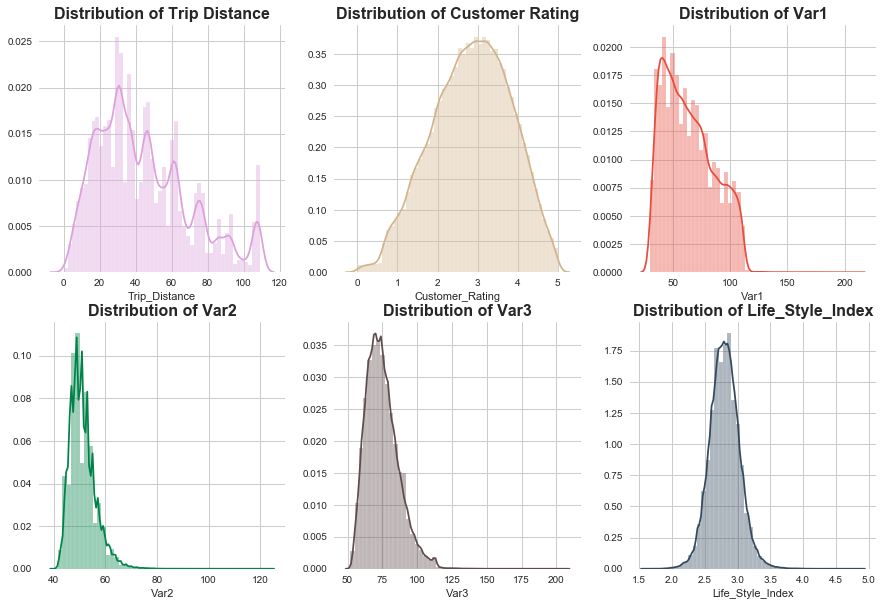

In [9]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot2grid((2,3),(0,0), rowspan=1, colspan=1)
sns.distplot(train.Trip_Distance, color='plum')
plt.title('Distribution of Trip Distance',weight='bold', fontsize=16)

ax1 = plt.subplot2grid((2,3),(0,1), rowspan=1, colspan=1)
sns.distplot(train.Customer_Rating, color='tan')
plt.title('Distribution of Customer Rating',weight='bold', fontsize=16)

ax1 = plt.subplot2grid((2,3),(0,2), rowspan=1, colspan=1)
sns.distplot(train.Var1.dropna(), color='#e74c3c')
plt.title('Distribution of Var1',weight='bold', fontsize=16)

ax2 = plt.subplot2grid((2,3),(1,0), rowspan=1, colspan=1)
sns.distplot(train.Var2, color='#008248')
plt.title('Distribution of Var2',weight='bold', fontsize=16)

ax2 = plt.subplot2grid((2,3),(1,1), rowspan=1, colspan=1)
sns.distplot(train.Var3, color='#604c4c')
plt.title('Distribution of Var3',weight='bold', fontsize=16)

ax2 = plt.subplot2grid((2,3),(1,2), rowspan=1, colspan=1)
sns.distplot(train['Life_Style_Index'].dropna(), color="#34495e")
plt.title('Distribution of Life_Style_Index', weight='bold', fontsize=16)

plt.show()

### Univariate Plots - categorical features 

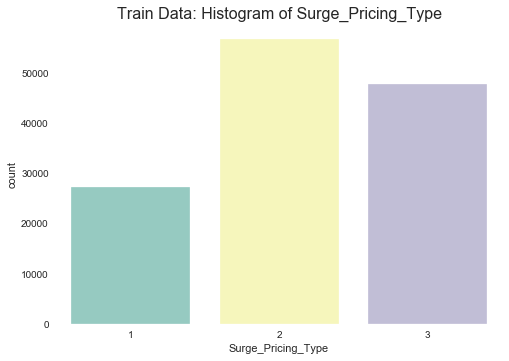

In [10]:
sns.set_style("white")

sns.countplot(train["Surge_Pricing_Type"], palette='Set3')
plt.title('Train Data: Histogram of Surge_Pricing_Type', fontsize=16)
plt.show()

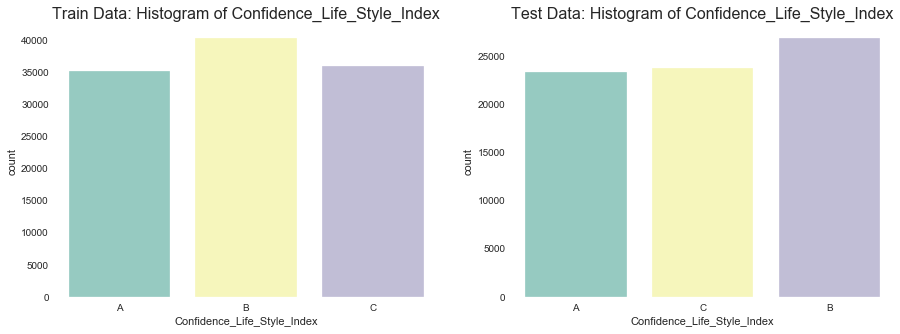

In [11]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.countplot(train["Confidence_Life_Style_Index"], palette='Set3')
plt.title('Train Data: Histogram of Confidence_Life_Style_Index', fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.countplot(test["Confidence_Life_Style_Index"], palette='Set3')
plt.title('Test Data: Histogram of Confidence_Life_Style_Index', fontsize=16)
plt.show()

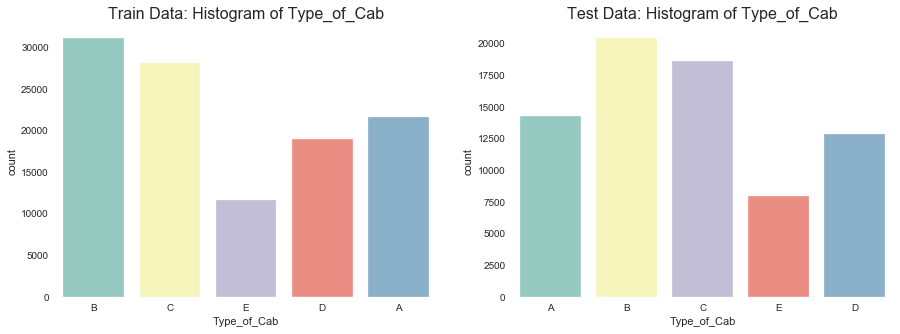

In [12]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.countplot(train["Type_of_Cab"], palette='Set3')
plt.title('Train Data: Histogram of Type_of_Cab', fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.countplot(test["Type_of_Cab"], palette='Set3')
plt.title('Test Data: Histogram of Type_of_Cab', fontsize=16)
plt.show()

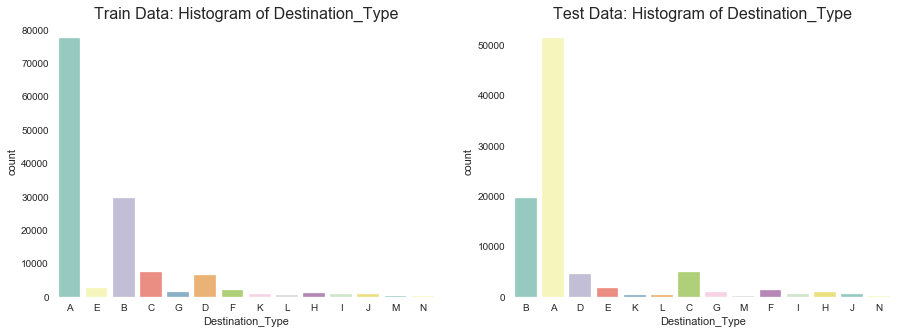

In [13]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.countplot(train["Destination_Type"], palette="Set3")
plt.title('Train Data: Histogram of Destination_Type', fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.countplot(test["Destination_Type"], palette="Set3")
plt.title('Test Data: Histogram of Destination_Type', fontsize=16)
plt.show()

### Univariate Plots - non continuous feature

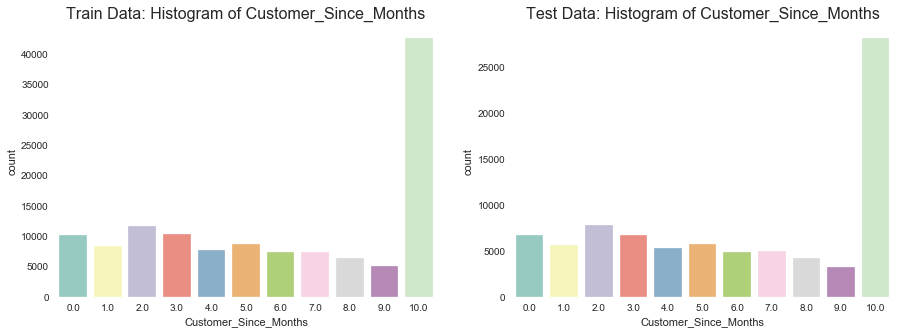

In [14]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.countplot(train["Customer_Since_Months"], palette="Set3")
plt.title('Train Data: Histogram of Customer_Since_Months', fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.countplot(test["Customer_Since_Months"], palette="Set3")
plt.title('Test Data: Histogram of Customer_Since_Months', fontsize=16)
plt.show()

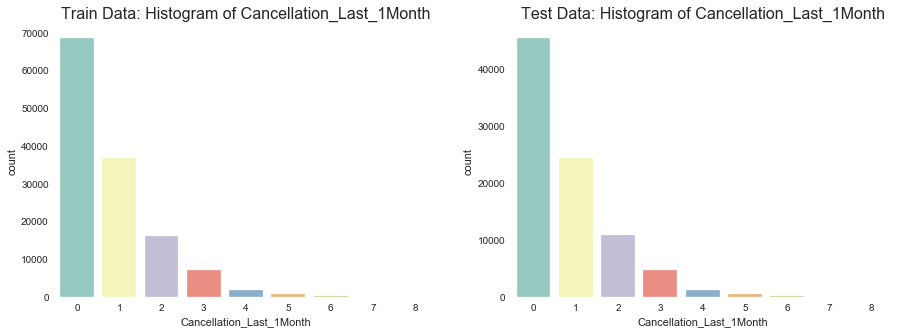

In [15]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.countplot(train["Cancellation_Last_1Month"], palette="Set3")
plt.title('Train Data: Histogram of Cancellation_Last_1Month', fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.countplot(test["Cancellation_Last_1Month"], palette="Set3")
plt.title('Test Data: Histogram of Cancellation_Last_1Month', fontsize=16)
plt.show()

### Bivariate Plots for train dataset

**1) Type_of_Cab and Customer_Rating**

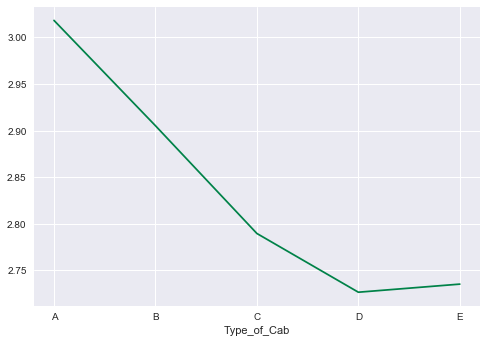

In [16]:
sns.set_style("darkgrid")

x = train.groupby("Type_of_Cab")["Customer_Rating"].mean().index
y = train.groupby("Type_of_Cab")["Customer_Rating"].mean().values
sns.lineplot(x,y, color='#008248')

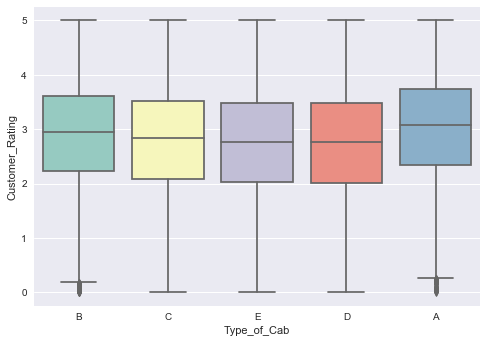

In [17]:
sns.boxplot(x="Type_of_Cab", y="Customer_Rating", data=train, palette="Set3")

**2) Type_of_Cab and Trip_Distance**

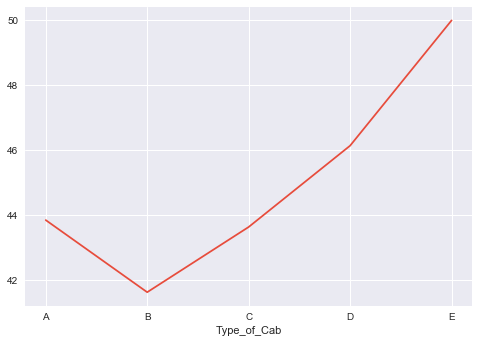

In [18]:
x = train.groupby("Type_of_Cab")["Trip_Distance"].mean().index
y = train.groupby("Type_of_Cab")["Trip_Distance"].mean().values
sns.lineplot(x,y, color='#e74c3c')

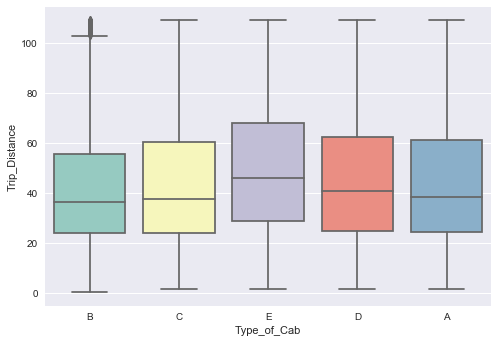

In [19]:
sns.boxplot(x="Type_of_Cab", y="Trip_Distance", data=train, palette="Set3")

**3) Customer_Since_Months and Customer_Rating**

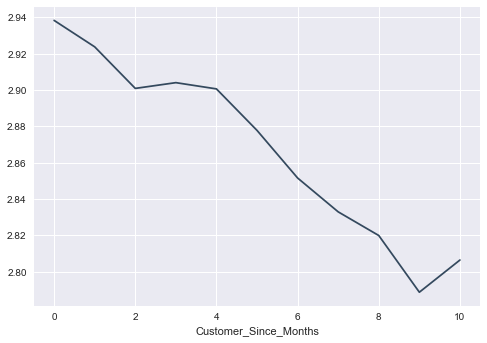

In [20]:
x = train.groupby("Customer_Since_Months")["Customer_Rating"].mean().index
y = train.groupby("Customer_Since_Months")["Customer_Rating"].mean().values
sns.lineplot(x,y, color='#34495e')

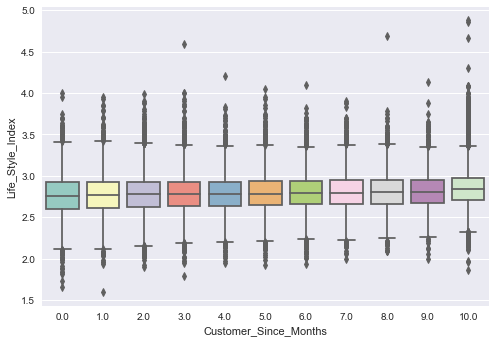

In [21]:
sns.boxplot(x="Customer_Since_Months", y="Life_Style_Index", data=train, palette="Set3")

**4) Customer_Since_Months and Cancellation_Last_1Month**

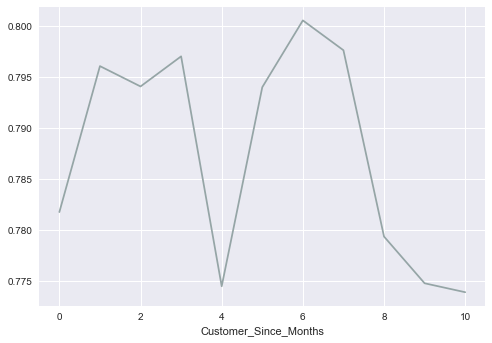

In [22]:
x = train.groupby("Customer_Since_Months")["Cancellation_Last_1Month"].mean().index
y = train.groupby("Customer_Since_Months")["Cancellation_Last_1Month"].mean().values
sns.lineplot(x,y, color='#95a5a6')

**5) Confidence_Life_Style_Index and Customer_Rating and Trip_Distance**

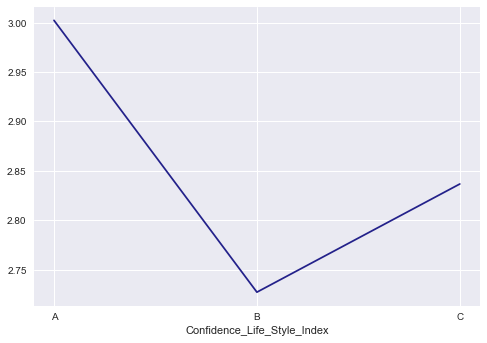

In [23]:
x = train.groupby("Confidence_Life_Style_Index")["Customer_Rating"].mean().index
y = train.groupby("Confidence_Life_Style_Index")["Customer_Rating"].mean().values
sns.lineplot(x,y, color='#23218a')

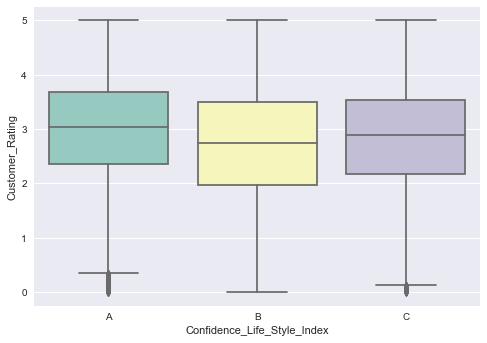

In [24]:
sns.boxplot(x="Confidence_Life_Style_Index", y="Customer_Rating", data=train, palette="Set3")

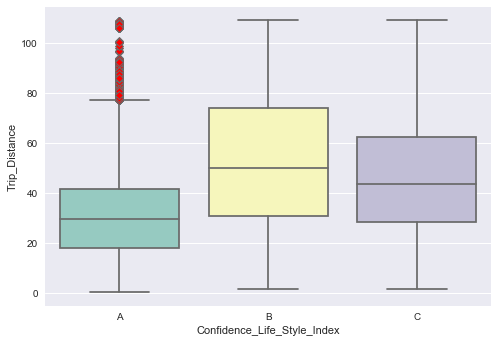

In [26]:
red_diamond = dict(markerfacecolor='r', marker='D')
sns.boxplot(x="Confidence_Life_Style_Index", y="Trip_Distance", palette="Set3", 
            flierprops=red_diamond, data=train)

**6) Destination_Type and Customer_Rating**

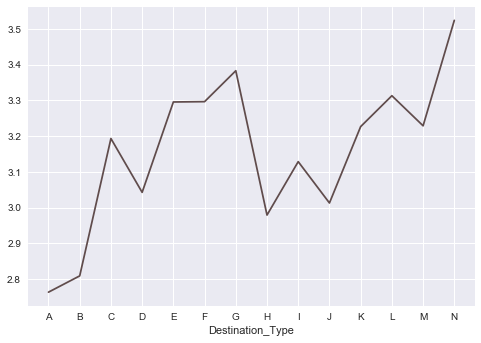

In [27]:
x = train.groupby("Destination_Type")["Customer_Rating"].mean().index
y = train.groupby("Destination_Type")["Customer_Rating"].mean().values
sns.lineplot(x,y, color='#604c4c')

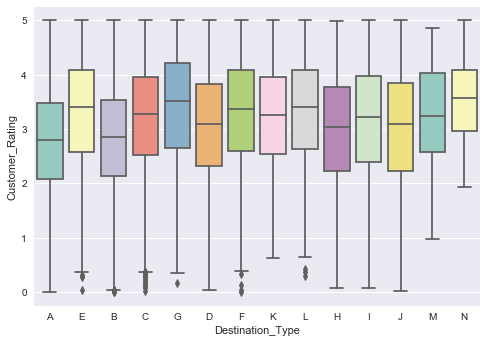

In [28]:
sns.boxplot(x="Destination_Type", y="Customer_Rating", palette="Set3", data=train)

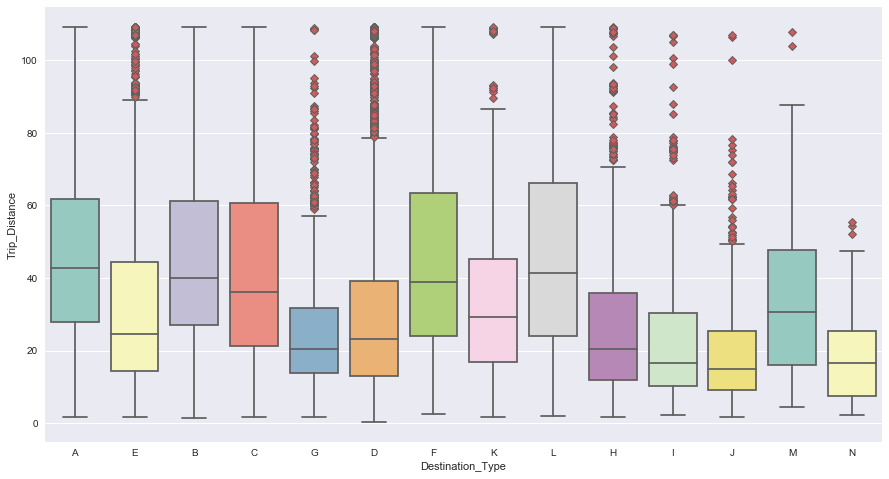

In [29]:
# Destination_Type and Trip_Distance 
fig = plt.figure(figsize=(15,8))
red_diamond = dict(markerfacecolor='indianred', marker='D')
sns.boxplot(x="Destination_Type", y="Trip_Distance", palette="Set3", flierprops=red_diamond, data=train)

**7) Surge_Pricing_Type and Trip_Distance and Customer_Rating**

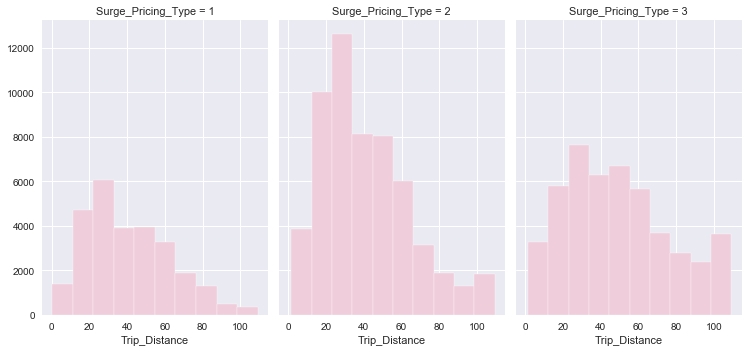

In [30]:
g = sns.FacetGrid(train, col="Surge_Pricing_Type", height=5, aspect=.7)
g = g.map(plt.hist, "Trip_Distance", color='#f0cddb')

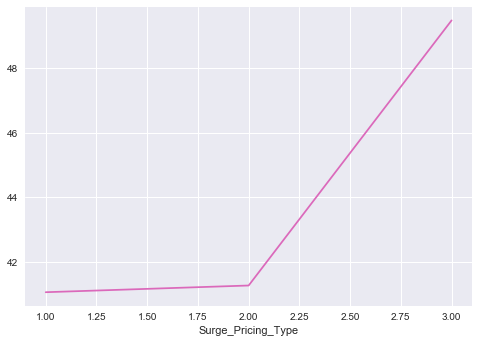

In [31]:
x = train.groupby("Surge_Pricing_Type")["Trip_Distance"].mean().index
y = train.groupby("Surge_Pricing_Type")["Trip_Distance"].mean().values
sns.lineplot(x,y, color='#db69bb')

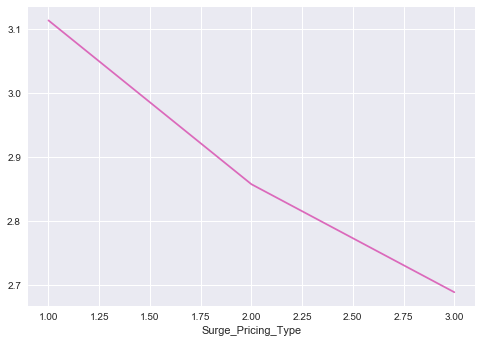

In [32]:
x = train.groupby("Surge_Pricing_Type")["Customer_Rating"].mean().index
y = train.groupby("Surge_Pricing_Type")["Customer_Rating"].mean().values
sns.lineplot(x,y, color='#db69bb')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.05, 'Pairplot for Surge_Pricing_Type')

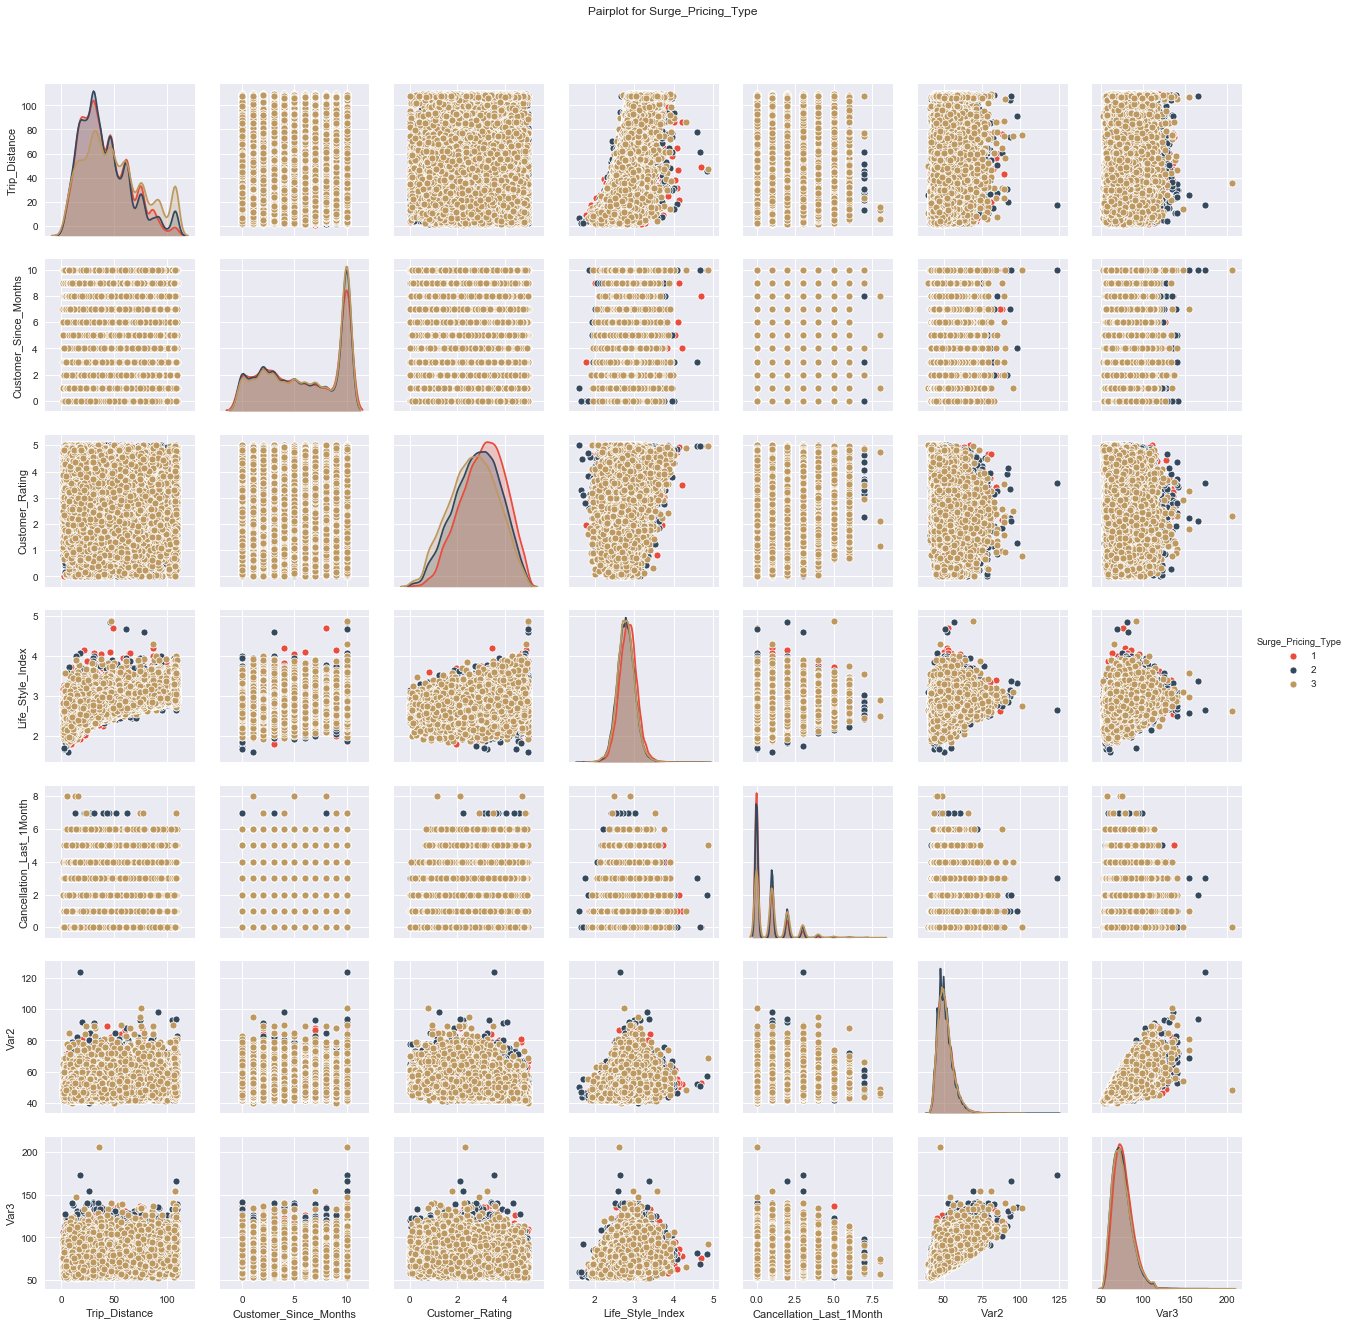

In [33]:
mycolor = ["#e74c3c", "#34495e", '#bd9860']
sns.set_palette(sns.color_palette(mycolor))
df = train[['Trip_Distance', 'Customer_Since_Months', 'Customer_Rating', 'Life_Style_Index', 
            'Cancellation_Last_1Month', 'Var2', "Var3", 'Surge_Pricing_Type']]

g = sns.pairplot(df,vars=df.columns[:-1], hue='Surge_Pricing_Type')
g.fig.suptitle("Pairplot for Surge_Pricing_Type", y=1.05)

## Feature engineering 

## Model development

### Random Forest - use data based on naive imputation

In [13]:
for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_filled_naive[var], prefix=var, drop_first=True)
    train_filled_naive = pd.concat([train_filled_naive, cat_list], axis = 1)
    train_filled_naive = train_filled_naive.drop(var, 1)

X1 = train_filled_naive.loc[:, 
                (train_filled_naive.columns!='Trip_ID') & (train_filled_naive.columns!='Surge_Pricing_Type')]
y1 = train_filled_naive["Surge_Pricing_Type"]
X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(X1, y1, 
                                                                            test_size=0.3, random_state=123)

rf_naive = RandomForestClassifier(n_estimators = 100, max_depth=30, random_state=0)
rf_naive.fit(X_train_naive, y_train_naive)
# predicting the test set results
y_pred_rf_naive = rf_naive.predict(X_test_naive)

# model performance parameters
from sklearn.metrics import confusion_matrix
confusion_matrix_naive = confusion_matrix(y_test_naive, y_pred_rf_naive)
print(confusion_matrix_naive)
print("OOS RF Accuracy:", rf.score(X_test_naive, y_test_naive))
y_pred_rf_naive

[[ 4676  2494   973]
 [  984 13233  2835]
 [  776  3993  9535]]
OOS RF Accuracy: 0.6933340084559103


array([1, 2, 3, ..., 2, 3, 3])

In [15]:
feature_list_naive = list(X1.columns)
# Get numerical feature importances
importances_naive = list(rf_naive.feature_importances_)
# List of tuples with variable and importance
feature_importances_naive = [(feature, round(importance, 2)) for feature, 
                       importance in zip(feature_list_naive, importances_naive)]
# Sort the feature importances by most important first
feature_importances_naive = sorted(feature_importances_naive, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_naive];

Variable: Trip_Distance        Importance: 0.12
Variable: Customer_Rating      Importance: 0.11
Variable: Life_Style_Index     Importance: 0.1
Variable: Var3                 Importance: 0.09
Variable: Type_of_Cab_B        Importance: 0.09
Variable: Type_of_Cab_D        Importance: 0.08
Variable: Var2                 Importance: 0.07
Variable: Customer_Since_Months Importance: 0.06
Variable: Var1                 Importance: 0.06
Variable: Type_of_Cab_C        Importance: 0.05
Variable: Cancellation_Last_1Month Importance: 0.03
Variable: Type_of_Cab_E        Importance: 0.03
Variable: Type_of_Cab_N        Importance: 0.03
Variable: Gender_Male          Importance: 0.02
Variable: Destination_Type_B   Importance: 0.01
Variable: Destination_Type_C   Importance: 0.01
Variable: Destination_Type_D   Importance: 0.01
Variable: Confidence_Life_Style_Index_B Importance: 0.01
Variable: Confidence_Life_Style_Index_C Importance: 0.01
Variable: Confidence_Life_Style_Index_N Importance: 0.01
Variable:

### Random Forest - use data based on knn imputation 

In [3]:
train_filled_knn = pd.read_csv("train_filled_knn.csv")
objList = ['Type_of_Cab', 'Destination_Type', 'Confidence_Life_Style_Index', 'Gender']

for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_filled_knn[var], prefix=var, drop_first=True)
    train_filled_knn = pd.concat([train_filled_knn, cat_list], axis = 1)
    train_filled_knn = train_filled_knn.drop(var, 1)

train_filled_knn.head()

,Trip_ID,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,...,Destination_Type_8.0,Destination_Type_9.0,Destination_Type_10.0,Destination_Type_11.0,Destination_Type_12.0,Destination_Type_13.0,Confidence_Life_Style_Index_1.0,Confidence_Life_Style_Index_2.0,Confidence_Life_Style_Index_3.0,Gender_1.0
0,T0005689460,6.77,1.0,2.427690,3.90500,0.0,40.000000,46.0,60.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,T0005689461,29.47,10.0,2.782450,3.45000,0.0,38.000000,56.0,78.0,2.0,...,0,0,0,0,0,0,1,0,0,1
2,T0005689464,41.58,10.0,2.881816,3.50125,2.0,35.971470,56.0,77.0,2.0,...,0,0,0,0,0,0,0,0,1,1
3,T0005689465,61.56,10.0,2.944906,3.45375,0.0,65.170181,52.0,74.0,3.0,...,0,0,0,0,0,0,0,0,1,1
4,T0005689467,54.95,10.0,3.034530,3.40250,4.0,51.000000,49.0,102.0,2.0,...,0,0,0,0,0,0,1,0,0,1


In [20]:
test_filled_knn = pd.read_csv("test_filled_knn.csv")
for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(test_filled_knn[var], prefix=var, drop_first=True)
    test_filled_knn = pd.concat([test_filled_knn, cat_list], axis = 1)
    test_filled_knn = test_filled_knn.drop(var, 1)

In [4]:
X = train_filled_knn.loc[:, 
                (train_filled_knn.columns!='Trip_ID') & (train_filled_knn.columns!='Surge_Pricing_Type')]
y = train_filled_knn["Surge_Pricing_Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [7]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=30, random_state=0)
rf.fit(X_train, y_train)
# predicting the test set results
y_pred_rf = rf.predict(X_test)

# model performance parameters
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix)
print("OOS RF Accuracy:", rf.score(X_test, y_test))
y_pred_rf

[[ 4591  2504  1048]
 [  964 13273  2815]
 [  782  4007  9515]]
OOS RF Accuracy: 0.6931567887794627


array([1., 2., 3., ..., 2., 3., 3.])

In [9]:
# Saving feature names for later use
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Trip_Distance        Importance: 0.11
Variable: Life_Style_Index     Importance: 0.1
Variable: Customer_Rating      Importance: 0.1
Variable: Var1                 Importance: 0.09
Variable: Type_of_Cab_1.0      Importance: 0.09
Variable: Var3                 Importance: 0.08
Variable: Type_of_Cab_3.0      Importance: 0.08
Variable: Var2                 Importance: 0.07
Variable: Customer_Since_Months Importance: 0.05
Variable: Type_of_Cab_2.0      Importance: 0.05
Variable: Cancellation_Last_1Month Importance: 0.03
Variable: Type_of_Cab_4.0      Importance: 0.03
Variable: Type_of_Cab_5.0      Importance: 0.03
Variable: Destination_Type_1.0 Importance: 0.01
Variable: Destination_Type_2.0 Importance: 0.01
Variable: Destination_Type_3.0 Importance: 0.01
Variable: Confidence_Life_Style_Index_1.0 Importance: 0.01
Variable: Confidence_Life_Style_Index_2.0 Importance: 0.01
Variable: Confidence_Life_Style_Index_3.0 Importance: 0.01
Variable: Gender_1.0           Importance: 0.01
Vari

### CatBoostClassifier (do not allow the existance of null values)

In [3]:
# Set up folds
kf = KFold(n_splits = 5, random_state = 0, shuffle = True)

In [4]:
train_filled_knn = pd.read_csv("train_filled_knn.csv")
test_filled_knn = pd.read_csv("test_filled_knn.csv")

In [5]:
train_filled_knn.Type_of_Cab = train_filled_knn.Type_of_Cab.astype(str)
train_filled_knn.Confidence_Life_Style_Index = train_filled_knn.Confidence_Life_Style_Index.astype(str)
train_filled_knn.Destination_Type = train_filled_knn.Destination_Type.astype(str)
train_filled_knn.Gender = train_filled_knn.Gender.astype(str)
train_filled_knn.Customer_Since_Months = train_filled_knn.Customer_Since_Months.astype(str)

test_filled_knn.Type_of_Cab = test_filled_knn.Type_of_Cab.astype(str)
test_filled_knn.Confidence_Life_Style_Index = test_filled_knn.Confidence_Life_Style_Index.astype(str)
test_filled_knn.Destination_Type = test_filled_knn.Destination_Type.astype(str)
test_filled_knn.Gender = test_filled_knn.Gender.astype(str)
test_filled_knn.Customer_Since_Months = test_filled_knn.Customer_Since_Months.astype(str)

In [6]:
X = train_filled_knn.drop(columns=['Trip_ID','Surge_Pricing_Type'],axis=1)
y = train_filled_knn['Surge_Pricing_Type']
X_test = test_filled_knn.drop(columns='Trip_ID',axis=1)
y_valid_pred = 0*y
y_test_pred = 0
accuracy = 0
result={}

#specifying categorical variables indexes
cat_columns = ['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender','Customer_Since_Months']

#fitting catboost classifier model
OPTIMIZE_ROUNDS = False
#j=1
model = CatBoostClassifier(n_estimators=1000, verbose=False)

for i, (train_index, test_index) in enumerate(kf.split(train_filled_knn)):
    
    print("\nFold {}".format(i+1))
    # Create data
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    #print( "\nFold ", j)
    
    # Run model
    if OPTIMIZE_ROUNDS:
        fit_model = model.fit( X_train, y_train, 
                               eval_set=[X_valid, y_valid], cat_features=cat_columns,
                               use_best_model=True
                             )
        print( "  N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train, cat_features=cat_columns )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(accuracy_score(y_valid, pred))
    accuracy += accuracy_score(y_valid, pred)
    # Accumulate test set predictions
    #y_test_pred += fit_model.predict(X_test)
    result[j]=fit_model.predict(X_test)
    #j+=1
# results = y_test_pred / 5  Average test set predictions
print(accuracy/5)


Fold  1
0.7016671097102495

Fold  2
0.7072494588539096

Fold  3
0.7056813003190034

Fold  4
0.6997189731125627

Fold  5
0.7019975694971897
0.703262882298583


In [9]:
df = pd.DataFrame()
for i in range(1, 6):
    df = pd.concat([df, pd.DataFrame(result[i])],axis=1)
df.columns=['1','2','3','4','5']

final = df.mode(axis=1)[0]

surge_price_type_pred_catboost = pd.read_csv('sample_submission.csv')
surge_price_type_pred_catboost.Surge_Pricing_Type = final
surge_price_type_pred_catboost.to_csv('surge_price_type_pred_catboost.csv',index = False)
surge_price_type_pred_catboost

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1.0
1,T0005689462,2.0
2,T0005689463,2.0
3,T0005689466,2.0
4,T0005689468,2.0
...,...,...
87390,T0005908503,2.0
87391,T0005908504,2.0
87392,T0005908505,1.0
87393,T0005908511,2.0


### LightGBM

allow the existance of missing values

In [3]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.5,
    'boost': 'gbdt',
    'feature_fraction': 0.7,
    'learning_rate': 0.005,
    'num_class':3,
    'metric':'multi_logloss',
    'max_depth': 8,  
    'num_leaves': 70,
    'min_data_in_leaf':40,
    'objective': 'multiclass',
    'scale_pos_weight':1,
    'device':'gpu',
    'verbosity': 1
}

In [5]:
objList = ['Type_of_Cab', 'Destination_Type', 'Confidence_Life_Style_Index', 'Gender']

for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train[var], prefix=var, drop_first=True)
    train = pd.concat([train, cat_list], axis = 1)
    train = train.drop(var, 1)
    
for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(test[var], prefix=var, drop_first=True)
    test = pd.concat([test, cat_list], axis = 1)
    test = test.drop(var, 1)
    
# in lightgbm, num_class=3 means [0,3) and it starts from 0
target_map = {1:0, 2:1, 3:2}
target_map_inverse = {0:1, 1:2, 2:3}
train["Surge_Pricing_Type"] = train["Surge_Pricing_Type"].map(target_map)

In [ ]:
features = [col for col in train.columns if col not in ["Trip_ID", "Surge_Pricing_Type"]]
y = train["Surge_Pricing_Type"]
skfolds = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

predictions = np.zeros((len(test), 3))
feature_importance_df = pd.DataFrame()
for fold_, (train_idx, val_idx) in enumerate(skfolds.split(train.values, y.values)):
    print("\nFold {}".format(fold_+1))
    
    train_data = lgb.Dataset(train.iloc[train_idx][features], label=y.iloc[train_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=y.iloc[val_idx])
    num_round = 1000000
    clf = lgb.train(param, train_data, num_round, 
                    valid_sets = [train_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    
    predictions_val = np.argmax(clf.predict(train.iloc[val_idx][features], 
                                            num_iteration=clf.best_iteration), axis=1)
    
    print("CV score: {:<8.5f}".format(accuracy_score(predictions_val, y.iloc[val_idx])))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / skfolds.n_splits

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False), 
           palette="Set3")
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [ ]:
submission = pd.read_csv("sample_submission.csv")
predictions_test = np.argmax(predictions, axis=1)
submission["Surge_Pricing_Type"] = predictions_test
submission["Surge_Pricing_Type"] = submission["Surge_Pricing_Type"].map(target_map_inverse)
submission.head()

### XGBoost

In [13]:
# prepare input
train_filled_knn = pd.read_csv("train_filled_knn.csv")
objList = ['Type_of_Cab', 'Destination_Type', 'Confidence_Life_Style_Index', 'Gender']

for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_filled_knn[var], prefix=var, drop_first=True)
    train_filled_knn = pd.concat([train_filled_knn, cat_list], axis = 1)
    train_filled_knn = train_filled_knn.drop(var, 1)
    
test_filled_knn = pd.read_csv("test_filled_knn.csv")
for var in objList:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(test_filled_knn[var], prefix=var, drop_first=True)
    test_filled_knn = pd.concat([test_filled_knn, cat_list], axis = 1)
    test_filled_knn = test_filled_knn.drop(var, 1)
    
X_train = train_filled_knn.loc[:, 
                (train_filled_knn.columns!='Trip_ID') & (train_filled_knn.columns!='Surge_Pricing_Type')]
y_train = train_filled_knn["Surge_Pricing_Type"]

X_test = test_filled_knn.loc[:, test_filled_knn.columns!='Trip_ID']

In [11]:
def getFeatureImportance(xgb, features):
    feat_vals = xgb.get_booster().get_fscore()
    feat_dict = {feat: float(feat_vals.get(feat, 0.)) for feat in features}
    total = sum(list(feat_dict.values()))
    return {k: round(v/total, 5) for k,v in feat_dict.items()}

In [14]:
# xgb_model = XGBClassifier()

# clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
#                    cv = StratifiedKFold(shuffle=True,n_splits=5), 
#                    scoring='accuracy',
#                    verbose=2, refit=True)

# there are 3 types of prices, given each record, xgb will give probs for each type
predictions = np.zeros((len(X_train),3))  
predictions_test = np.zeros((len(X_test),3))
features = [feat for feat in X_train.columns]
skfolds = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

for fold, (train_index, validation_index) in enumerate(skfolds.split(X_train, y_train)):
    print("\nFold {}".format(fold+1))
    
    # initialize XGB Classifer
    xgb = XGBClassifier(n_estimators=800, verbosity=1, objective="multi:softprob",
                        learning_rate =0.05, num_class =3, eval_metric="mlogloss")
    
    # use the train data to fit the XGB classifer
    xgb.fit(X_train.iloc[train_index][features], y_train.iloc[train_index])
    print("The feature importance is: ", getFeatureImportance(xgb, features))
    # get the best iteration parameter
    best_iteration = xgb.get_booster().best_ntree_limit
    # make predictions for the out of folder observations
    oos = xgb.predict_proba(X_train.iloc[validation_index][features], ntree_limit=best_iteration)
    # make predictions for all train data
    predictions += xgb.predict_proba(X_train, ntree_limit=best_iteration)
    # make predictions for test data
    predictions_test += xgb.predict_proba(X_test, ntree_limit=best_iteration)
    
    # for each trip id, retrieve the price type with highest prediction probabilities
    pred_train = pd.DataFrame([np.argmax(pr) for pr in predictions]) #np.argmax: return indices of the maximum values
    pred_oos = pd.DataFrame([np.argmax(pr) for pr in oos])
    # calculate in-sample accuracy scores
    acc_score = accuracy_score(y_train, pred_train)
    # calculate out-of-sample accuracy scores
    oos_acc = accuracy_score(y_train.iloc[validation_index], pred_oos)      
    print("\nTraining accuracy {} and OOS accuracy {}".format(acc_score, oos_acc))


Fold 1
The feature importance is:  {'Trip_Distance': 0.16446, 'Customer_Since_Months': 0.05172, 'Life_Style_Index': 0.1584, 'Customer_Rating': 0.15162, 'Cancellation_Last_1Month': 0.03316, 'Var1': 0.13883, 'Var2': 0.06714, 'Var3': 0.0931, 'Type_of_Cab_1.0': 0.01171, 'Type_of_Cab_2.0': 0.01751, 'Type_of_Cab_3.0': 0.00739, 'Type_of_Cab_4.0': 0.00695, 'Type_of_Cab_5.0': 0.00896, 'Destination_Type_1.0': 0.01336, 'Destination_Type_2.0': 0.00445, 'Destination_Type_3.0': 0.00693, 'Destination_Type_4.0': 0.00289, 'Destination_Type_5.0': 0.00355, 'Destination_Type_6.0': 0.00231, 'Destination_Type_7.0': 0.00235, 'Destination_Type_8.0': 0.00289, 'Destination_Type_9.0': 0.00196, 'Destination_Type_10.0': 0.002, 'Destination_Type_11.0': 0.00241, 'Destination_Type_12.0': 0.00093, 'Destination_Type_13.0': 0.00089, 'Confidence_Life_Style_Index_1.0': 0.01335, 'Confidence_Life_Style_Index_2.0': 0.0105, 'Confidence_Life_Style_Index_3.0': 0.00846, 'Gender_1.0': 0.00981}

Training accuracy 0.12075617870000

In [16]:
test_result={}

for fold, (train_index, validation_index) in enumerate(skfolds.split(X_train, y_train)):
    print("\nFold {}".format(fold+1))
    
    # initialize XGB Classifer
    xgb = XGBClassifier(n_estimators=800, verbosity=1, objective="multi:softprob",
                        learning_rate =0.05, num_class =3, eval_metric="mlogloss")
    
    # use the train data to fit the XGB classifer
    xgb.fit(X_train.iloc[train_index][features], y_train.iloc[train_index])
    print("The feature importance is: ", getFeatureImportance(xgb, features))
    # get the best iteration parameter
    best_iteration = xgb.get_booster().best_ntree_limit
    # make predictions for the out of folder observations
    pred_oos = xgb.predict(X_train.iloc[validation_index][features], ntree_limit=best_iteration)
    # make predictions for all train data
    pred_train = xgb.predict(X_train, ntree_limit=best_iteration)
    # make predictions for test data
    test_result[fold]= xgb.predict(X_test, ntree_limit=best_iteration)
    
    # calculate in-sample accuracy scores
    acc_score = accuracy_score(y_train, pred_train)
    # calculate out-of-sample accuracy scores
    oos_acc = accuracy_score(y_train.iloc[validation_index], pred_oos)      
    print("\nTraining accuracy {} and OOS accuracy {}".format(acc_score, oos_acc))


Fold 1
The feature importance is:  {'Trip_Distance': 0.16446, 'Customer_Since_Months': 0.05172, 'Life_Style_Index': 0.1584, 'Customer_Rating': 0.15162, 'Cancellation_Last_1Month': 0.03316, 'Var1': 0.13883, 'Var2': 0.06714, 'Var3': 0.0931, 'Type_of_Cab_1.0': 0.01171, 'Type_of_Cab_2.0': 0.01751, 'Type_of_Cab_3.0': 0.00739, 'Type_of_Cab_4.0': 0.00695, 'Type_of_Cab_5.0': 0.00896, 'Destination_Type_1.0': 0.01336, 'Destination_Type_2.0': 0.00445, 'Destination_Type_3.0': 0.00693, 'Destination_Type_4.0': 0.00289, 'Destination_Type_5.0': 0.00355, 'Destination_Type_6.0': 0.00231, 'Destination_Type_7.0': 0.00235, 'Destination_Type_8.0': 0.00289, 'Destination_Type_9.0': 0.00196, 'Destination_Type_10.0': 0.002, 'Destination_Type_11.0': 0.00241, 'Destination_Type_12.0': 0.00093, 'Destination_Type_13.0': 0.00089, 'Confidence_Life_Style_Index_1.0': 0.01335, 'Confidence_Life_Style_Index_2.0': 0.0105, 'Confidence_Life_Style_Index_3.0': 0.00846, 'Gender_1.0': 0.00981}

Training accuracy 0.73783627774148

In [18]:
test_result

{0: array([1., 2., 2., ..., 1., 2., 2.]),
 1: array([1., 2., 2., ..., 1., 2., 2.]),
 2: array([1., 2., 2., ..., 1., 2., 2.]),
 3: array([1., 2., 2., ..., 1., 2., 2.]),
 4: array([1., 2., 2., ..., 1., 2., 2.])}

In [21]:
df_xgb = pd.DataFrame()
for i in range(5):
    df_xgb = pd.concat([df_xgb, pd.DataFrame(test_result[i])], axis=1)
df_xgb.columns=['1','2','3','4','5']

final_xgb = df_xgb.mode(axis=1)[0]

surge_price_type_pred_xgb = pd.read_csv('sample_submission.csv')
surge_price_type_pred_xgb.Surge_Pricing_Type = final_xgb
surge_price_type_pred_xgb.to_csv('surge_price_type_pred_xgb.csv',index = False)
surge_price_type_pred_xgb

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1.0
1,T0005689462,2.0
2,T0005689463,2.0
3,T0005689466,2.0
4,T0005689468,2.0
...,...,...
87390,T0005908503,2.0
87391,T0005908504,2.0
87392,T0005908505,1.0
87393,T0005908511,2.0
